In [1]:
from IPython.display import YouTubeVideo, Markdown, SVG, Code
from functools import partial
YouTubeVideo_formato = partial(YouTubeVideo, modestbranding=1, disablekb=0,
                               width=640, height=360, autoplay=0, rel=0, showinfo=0)

display(Markdown(filename='../../preamble.md'))

### Instrucciones  y metodología asíncrona
Hola a todas y todos

- Este notebook forma parte del curso **INFO147: Computación científica con Python** de la carrera de Ingeniería Civil Informática de la Universidad Austral de Chile
- El profesor responsable es **Pablo Huijse**, por favor hacer sus consultas por slack o al correo phuijse at inf dot uach dot cl
- El material del curso se encuentra en https://github.com/magister-informatica-uach/INFO147 
- Se recomienda tener una copia local actualizada del repositorio


Para estudiar este material de forma asíncrona se recomienda seguir el flujo que se presenta a continuación

```bash 
for sección in notebook
do
    leer(sección) # Para incorporar los nuevos contenidos
    if ejercicios in sección
        resolver(ejercicios) # Para poner en práctica lo aprendido
    if video in sección
        ver(video) # Para profundizar y analizar la solución del ejercicio
done
```

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Python y  Rendimiento | Parte 1

Python es un lenguaje interpretado de alto nivel que es muy conveniente para prototipar y hacer análisis 
exploratorio

Esto tiene un costo: Menor **rendimiento** a igual **complejidad** en comparación a lenguajes compilados de bajo nivel

Podemos ser más específicos y hablar de **eficiencia**:

> Eficiencia temporal: Tiempo para completar una tarea (tiempo en la CPU)

> Eficiencia espacial: Utilización de espacio (memoria RAM, disco)

Ambos son factores críticos en algunas aplicaciones, por ejemplo aplicaciones con muchos datos o mucho cómputo

Existe entonces una necesidad por mejorar el rendimiento de nuestro código

> A esto lo llamamos **Optimización** de código

En el siguiente cuadernillo veremos distintas formas de **optimizar** código escrito en Python

Sin embargo antes de optimizar es necesario diagnosticar e identificar los sectores críticos (cuellos de botella) de nuestro programa

> Esto lo llamamos *Profiling* de código


# *Profiling*

Se refiere a medir los 

1. Tiempos de ejecución (total, por función, por linea)
1. Uso de recursos (memoria, cpu, disco)

de una rutina con el fin de encontrar aquellas secciones más lentas e ineficientes (sectores críticos)

Luego de identificarlas podemos reescribirlas u optimizarlas

En esta clase veremos como hacer un *profiling* de nuestro código en Python usando el ambiente *Jupyter* y las magias de *IPython*

## Ejemplo de caso: Set de Julia

A modo de ejemplo haremos *profiling* de un script de Python que calcula el famoso fractal conocido como el Set de Julia

El [set de Julia](https://en.wikipedia.org/wiki/Julia_set) es un fractal asociado a la función

$$
f(z) = z^2 + c,
$$
donde $c \in \mathbb{C}$

El script [fractal.py](./fractal.py) tiene una implementación del set de Julia usando Python puro, es decir sin usar librerias

In [3]:
Code(filename="fractal.py")

def evaluate_z(zi, zr, maxiters=50, cr=-0.835, ci=-0.2321):
    nit = 0
    zi2 = zi**2
    zr2 = zr**2
    while zi2 + zr2 <= 4. and nit < maxiters:
        zi = 2*zr*zi + ci
        zr = zr2 - zi2 + cr
        zr2 = zr**2
        zi2 = zi**2 
        nit +=1
    return nit
    
def make_fractal(N, maxiters=50):
    image = []
    for i in range(N):
        row = []
        for j in range(2*N):
            zi = -1.0 + i*2/N
            zr = -2.0 + j*2/N
            row.append(evaluate_z(zi, zr, maxiters))
        image.append(row)
    return image

Si ejecutamos la función `make_fractal` con una resolución de 500 pixeles y 50 iteraciones el resultado es

<IPython.core.display.Javascript object>


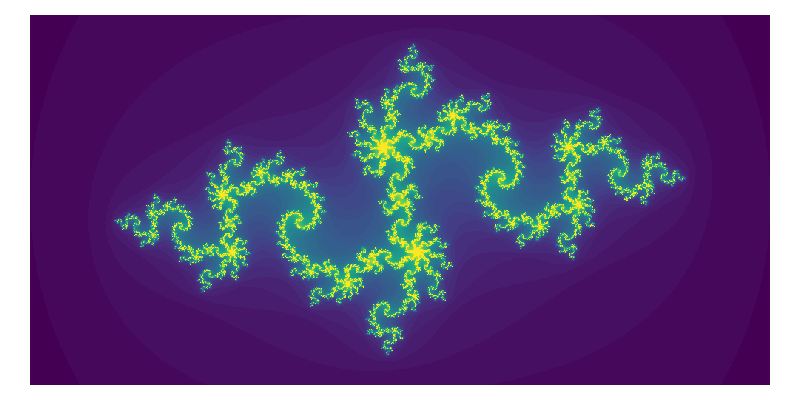

In [4]:
from fractal import make_fractal, evaluate_z

fractal_image = make_fractal(N=500, maxiters=50)

fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
ax.imshow(fractal_image, aspect='equal', cmap=plt.cm.viridis, origin='lower')
ax.axis('off');

# Medir tiempo de ejecución

## Tiempo total usando magias de IPython



A continuación revisaremos algunas magias de IPython que nos permiten medir el tiempo de ejecución de un script, función o expresión de Python de forma simple y conveniente

La primera es `%time` que se usa anteponiendose a una función

```python
>>> %time mi_resultado = mi_funcion(mis_argumentos)
```

Esto retorna algo similar a 

```
CPU times: user 2.44 s, sys: 2.41 ms, total: 2.45 s
Wall time: 2.57 s
```

donde

- *Wall time*: Es el tiempo total de un proceso/función/expresión desde su principio (lanzamiento) hasta su fin (retorno)
- *CPU time (total)*: Es el tiempo en que el CPU está dedicado procesando la tarea solicitada, siempre será menor que el *Wall-time*

La magia `%time` mide el tiempo de una linea de código

Si queremos medir el tiempo de todas las lineas de código de un bloque de ejecución se usa `%%time`

### Ejemplo

Midamos el tiempo que demora en calcularse el fractal de Julia

Usaremos la magia `%time`

¿Cuánto demora en calcularse la función `slow_function`?

In [5]:
%time result1 = make_fractal(N=500, maxiters=50)

CPU times: user 2.44 s, sys: 0 ns, total: 2.44 s
Wall time: 2.47 s


¿Qué ocurre si medimos una segunda vez?

In [6]:
%time result2 = make_fractal(N=500, maxiters=50)

CPU times: user 2.47 s, sys: 6.36 ms, total: 2.48 s
Wall time: 2.49 s


In [7]:
np.allclose(result1, result2)

True

Notemos que que el resultado en ambos casos es idéntico

> Pero el tiempo de ejecución es ligeramente distinto

¿Por qué?

> Cada vez que ejecutamos un código alteramos el estado de nuestro sistema (cache, memoria)

Por ende lo más correcto para medir el tiempo de nuestra rutina sería ejecutarla varias veces y calcular un promedio

### La magía `%timeit`

Podemos medir el tiempo promedio de un script, función o expresión de Python de forma conveniente usando la magia `timeit`. Esta magia se basa en el módulo estándar de Python [timeit](https://docs.python.org/3/library/timeit.html)

Esta magia tiene varios argumentos, a continuación revisaremos un subconjunto de ellos

- `-r<R>`: Define que el algoritmo se repetira `<R>` veces y se retorna el tiempo promedio
- `-n<N>`: Define que cada repetición se ejecutará `<N>` veces guardando el tiempo de la mejor (más rápida)
- `-p<P>`: Se usa una precisión de `<P>` dígitos en los resultados
- `-q`: No imprimir los resultados
- `-o`: Retorna un objeto `TimeitResult`, con esto podemos manipular, analizar y graficar los tiempos de ejecución
   
se pueden revisar los demás argumentos en [la documentación](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time)

Esta magia se utiliza como 

```python
>>> %timeit -r10 -n5 mi_funcion(mis_argumentos)

```
en el ejemplo se retornará el promedio y la desviación estándar de 10 tiempos, donde cada uno es el mejor de 5 ejecuciones de `mi_funcion()`



### Ejercicio

1. Cree cinco fractales usando `maxiters=50`y los valores `N` [5, 10, 50, 100, 500] y gráfique cada uno para apreciar sus diferencias
1. Use `%timeit` para calcular el tiempo promedio y la desviación estándar de la función `make_fractal` con `N=500` y `maxiters=50`. Utilice `<R>=10` y `<N>=5`
1. Repita lo anterior para cada uno de los valores de `N` usados anteriormente, guarde los tiempos asociados (Hint: estudie el atributo `-o`) y muestre una gráfica de $N$ vs tiempo total con barras de error. Considere escalamiento logarítmico para los ejes

In [8]:
# Completa aquí


## Tiempo función por función

Midiendo el tiempo de cada función con cProfile

El módulo de Python [cProfile](https://docs.python.org/3/library/profile.html) mide la cantidad de llamadas y el tiempo de cada función ejecutada por nuestra rutina

La magia de IPython `%prun` nos da una forma conveniente para usar este módulo

```python
>>> %prun mi_funcion()
```

Esto devuelve  una tabla con las siguientes filas

- ncalls: Número de veces que se llama la función
- tottime: Tiempo total en dicha función (sin contar subfunciones)
- percall: ttime/ncalls
- cumtime: Tiempo total en dicha función y sus subfunciones (tiempo de función recursiva)
- percall: cumtime/ncalls

Opciones importantes de `%prun`
- `-s` para que el resultado quede ordenado según una fila en particular 
- `-l` si queremos especificar la cantidad de líneas a mostrar en la tabla

### Ejemplo

Usemos `prun` en la función `make_fractal` ordenando según el tiempo acumulado

In [9]:
%prun -s cumtime make_fractal(N=500, maxiters=50)

De la tabla vemos que 
- La función con mayor tiempo total es `evaluate_z` que está en la linea 1 de fractal.py
- `evaluate_z()` se llama 500.000 veces

En general el tiempo total es mayor que el que medimos con `time` y `timeit`. Esto se debe al overhead de `prun`

### Visualizando el resultado de `prun`

Podemos generar una visualización de los resultados de `cProfile` en nuestro navegador usando [`SnakeViz`](https://jiffyclub.github.io/snakeviz/)

Primero lo instalamos con

    conda install snakeviz
    
Esto creará un ejecutable `snakeviz` 

Luego cargamos la extensión para jupyter. Esto habilitará la magia del mismo nombre que podemos usar como

```python

    >>> %load_ext snakeviz
    >>> %snakeviz -t make_fractal(N=500, maxiters=50)
```

La opción `-t` carga el gráfico en una pestaña de navegador nueva

Esta herramienta puede mejorar considerablemente el estudio de nuestro código cuando se tiene una gran cantidad de funciones en distintas jerarquías

<img src="../img/snakeviz.png" width="900">

### `cProfile` sin IPython

Si no contamos con el ambiente IPython podemos usar cProfile directamente sobre un script de Python con

        python -m cProfile -o tabla.prof script.py
        
Donde el resultado queda grabado en el archivo tabla.prof

## Tiempo linea a linea

Hemos visto como medir el tiempo total de un código en Python y el tiempo desglosado por cada llamado a función de dicho código

Pero en ocasiones puede resultar más informativo estudiar el tiempo de ejecución de cada linea de nuestro código por separado

> Esto corresponde a un tipo de *profiling* llamado *line by line*

Podemos hacer este tipo de profiling usando la extensión externa [`line_profiler`](https://github.com/rkern/line_profiler)

Para instalar puedes usar conda

    conda install line_profiler

Una vez instalada debes cargar la extensión, lo cual habilitará una nueva magia llamada `%lprun`

> La magia `%lprun` que funciona de forma similar a `prun`

```python
>>> %load_ext line_profiler
>>> %lprun -f mi_método mi_rutina
```

Esta magia requiere que se especifique un método o función dentro de la rutina con el argumento `-f`

Ejecutar la magia levantará una pestaña con una tabla

La tabla tiene una fila por linea de código y las siguientes columnas
- Line: Número de la linea dentro del código fuente
- Hits: La cantidad de veces que se llama a esa linea
- Time: Tiempo total de dicha linea
- Per hit: Tiempo total dividido la cantidad de llamadas
- % Time: Porcentaje del tiempo de dicha linea con respecto al tiempo total del método

### Ejercicio

- Realice un *line by line profiling* de `make_fractal`. ¿Cuál es la linea más costosa? ¿Qué porcentaje representa del total de tiempo de la función?
- Realice un profiling de la función correspondiente a la linea más costosa

In [10]:
# Completa aquí


# Medir uso de memoria

## Memoría total y linea a linea con magias de IPython

De forma muy similar a `timeit` para medir el tiempo de una rutina existe la magia `memit` para medir la cantidad de memoría usada por una rutina

La magia es externa a IPython y debemos instalarla con

    conda install memory_profiler
    
Luego se habilita y usa con

```python
>>> %load_ext memory_profiler
>>> %memit funcion()
```

Que retorna la cantidad de memoria RAM usada por `funcion`

Con esto también se habilita la magia `%mprun` para medir el uso de memoria linea a linea


## Extra: Uso de memoria con módulo `tracemalloc`

Python tiene un módulo estándar llamado [`tracemalloc`](https://docs.python.org/3/library/tracemalloc.html) que permite calcular estadísticas sobre la memoria alocada por un proceso o script de Python

```python
import tracemalloc

tracemalloc.start()

# Acá se corre el código que quieres estudiar

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')

```
